### This Notebook solves the stochastic growth model with logarithmic utility and Markovian shocks using value function iteration and a continuos state space of capital. Iterations performed with loops. The Value function is linearly interpolated for any value of the technology shock.


#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline 

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The function markov_approx is copied below.

In [2]:
# markovapprox: approximates a continuous AR(1) process with a Markov chain
# Eva Carceles-Poveda's version. You can use this function, Floden's tauchen function, or Sargent's tauchen function.

from scipy.stats import norm
def markov_approx(rho, sigma, m, N):
    """ Syntax: [Tran,s,p,arho,asigma]=markovapprox(rho,sigma,m,N)
    
    This function approximates a first-order autoregressive process 
    with persistence rho and innovation standard deviation sigma with 
    an N state Markov chain; m determines the width of the discretized 
    state space, Tauchen uses m=3, with ymax=m*vary,ymin=-m*vary, where 
    ymax and ymin are the two boundary points, Tran is the transition 
    matrix of the Markov chain, s is the discretized state space, p is 
    the chain stationary distribution, arho is the theoretical first 
    order autoregression coefficient for the Markov chain, asigma is 
    the theoretical standard deviation for the Markov chain.
    
    Translated from Eva Carceles-Poveda 2003 MATLAB code
    """
    
    # Discretize the state space
    stvy = np.sqrt(sigma**2/(1-rho**2))   # standard deviation of y(t)
    ymax = m*stvy                         # upper boundary of state space
    ymin = -ymax                          # lower boundary of state space
    w = (ymax-ymin)/(N-1)                 # distance between points
    s = w * np.arange(ymin/w, ymax/w+1)   # the discretized state space        
    
    
    # Calculate the transition matrix
    Tran = np.zeros((N,N))
    for j in np.arange(0,N):
        for k in np.arange(1,N-1):
            Tran[j,k] = norm.cdf(s[k]-rho*s[j]+w/2,0,sigma) - norm.cdf(s[k]-rho*s[j]-w/2,0,sigma);
            
        Tran[j,0] = norm.cdf(s[0]-rho*s[j]+w/2,0,sigma);
        Tran[j,N-1] = 1 - norm.cdf(s[N-1]-rho*s[j]-w/2,0,sigma);
        
    # Check that Tran is well specified
    if not np.all(np.isclose(np.sum(Tran.T, axis=0), np.squeeze(np.ones((1,N))))):
        # find rows not adding up to one
        str = (np.absolute(np.sum(Tran.T, axis=0))-np.squeeze(np.ones((1,N)))<1e-14).nonzero()          
        print('error in transition matrix')
        print('rows', str[0],' do not sum to one')
    
    
    # Calculate the invariant distribution of Markov chain
    Trans = Tran.T
    p = (1/N)*np.ones((N,1)) # initial distribution of states
    test = 1;
    while test > 1e-8:
        p1 = np.matmul(Trans,p)
        test=np.max(np.abs(p1-p))
        p = p1
    
    
    meanm = np.matmul(s,p)            # mean of invariant distribution of chain
    varm = np.matmul((s-meanm)**2,p)  #variance of invariant distribution of chain  
    midaut1 = np.matmul((s-meanm)[:, np.newaxis],(s-meanm)[np.newaxis, :]) # cross product of deviation from mean of yt and yt-1                    
    probmat = np.matmul(p,np.ones((1,N)))     # each column is invariant distribution   
    midaut2 = Tran*probmat*midaut1 # product of the first two terms is joint distribution of (Yt-1,Yt)                                    
    autcov1 = np.sum(midaut2)    #  first-order auto-covariance
    
    
    arho = autcov1/varm           # theoretical first order autoregression coefficient
    asigma = np.sqrt(varm)           # theoretical standard deviation
    
    return Tran, s, p, arho, asigma

In [3]:
# Model Parameters
delta = 0.1
alfa = 0.33
A = 1
beta = 0.9

# Algorithm parameters
tolv = 1e-5 #tolerance, equals 1*10^-7
simyes = 1 # simulates model
stationary = 1 # finds stationary distribution for capital

In [4]:
# Define the shock
rho = 0.95
sigmae = 0.00712
N = 7
m = 3
Pi, teta, P, arho, asigma = markov_approx(rho,sigmae,m,N)
teta = np.exp(teta)

#P = np.linalg.matrix_power(Pi, 10000) # stationary distribution

lt=teta.size

In [5]:
# Grid for capital
lk = int(input('Enter the number of grid points for the capital: '))
k_min = 1
k_max = 3
grk = (k_max-k_min)/(lk-1)
k = np.arange(k_min,k_max+grk,grk)
#k = np.linspace(k_min,k_max,lk).T

Enter the number of grid points for the capital: 300


In [6]:
# Calculate disposable income (c+k)
yd = np.zeros((lk,lt))

for j in np.arange(0,lt):
    for i in np.arange(0,lk):
        yd[i,j] = teta[j]*k[i]**alfa+(1-delta)*k[i]



In [7]:
def maxlininterpol(kpr, V0, beta, inc, Pi, j, k):
    pos=np.abs(kpr-k).argmin()

    if k[pos] > kpr:
        weight = (k[pos]-kpr)/(k[pos]-k[pos-1])
        y = np.log(inc-kpr) + beta*np.dot(weight*V0[pos-1,:]+(1-weight)*V0[pos,:],Pi[j,:]).T
    elif k[pos] == kpr:
        y = np.log(inc-kpr) + beta*np.dot(V0[pos,:],Pi[j,:]).T
    else:
        weight = (kpr-k[pos])/(k[pos+1]-k[pos])
        y = np.log(inc-kpr) + beta*np.dot(weight*V0[pos+1,:]+(1-weight)*V0[pos,:],Pi[j,:]).T

    y=-y;
    #print('y=',y)
    return y

In [8]:
# This is used for the fminbound function
from scipy import optimize

# This is used to calculate the excution time of the while loop
import time


# Initialization of the value function
V0 = np.ones((lk,lt))
V1 = np.zeros((lk,lt))
kpr = np.zeros((lk,lt))

iteration = 0
start = time.perf_counter()
while np.abs(V1-V0).max(axis=0).max() > tolv:
    V0 = V1.copy()
    for j in np.arange(0,lt):
        for i in np.arange(0,lk):
            inc = yd[i,j]
            kpr[i,j]=optimize.fminbound(func=maxlininterpol,x1=k[0],x2=min(yd[i,j]-0.00001,k[lk-1]),\
                                        args=(V0,beta,inc,Pi,j,k,),xtol=1e-04)
            #print("kpr=",kpr[i,j])
            V1[i,j]=-maxlininterpol(kpr[i,j],V0,beta,inc,Pi,j,k)
    iteration = iteration + 1
    print("iteration =", iteration, ", max(V1-V0) = ", np.abs((V1-V0)).max(axis=0).max())


# Compute the optimal conusmption policy
polc=A*np.dot(teta[:,np.newaxis],np.ones((1,lk))).T*(np.dot(k[:,np.newaxis]**(alfa),np.ones((1,lt)))) + \
(1-delta)*np.dot(k[:,np.newaxis],np.ones((1,lt))) - kpr

stop = time.perf_counter()

print("Elapsed time in seconds for the while loop is:", round(stop - start,4))

iteration = 1 , max(V1-V0) =  1.1751622592333713
iteration = 2 , max(V1-V0) =  0.3169209550763701
iteration = 3 , max(V1-V0) =  0.1641982307707457
iteration = 4 , max(V1-V0) =  0.11906543104638845
iteration = 5 , max(V1-V0) =  0.10224485210154377
iteration = 6 , max(V1-V0) =  0.08763579616865269
iteration = 7 , max(V1-V0) =  0.07509966904177234
iteration = 8 , max(V1-V0) =  0.06444618953189918
iteration = 9 , max(V1-V0) =  0.055401067065522946
iteration = 10 , max(V1-V0) =  0.04773079713920447
iteration = 11 , max(V1-V0) =  0.04123140171556461
iteration = 12 , max(V1-V0) =  0.035700747336049776
iteration = 13 , max(V1-V0) =  0.030985027958314593
iteration = 14 , max(V1-V0) =  0.026947834857558917
iteration = 15 , max(V1-V0) =  0.023485122080164622
iteration = 16 , max(V1-V0) =  0.020507557785659936
iteration = 17 , max(V1-V0) =  0.017934211853017468
iteration = 18 , max(V1-V0) =  0.015708865211180312
iteration = 19 , max(V1-V0) =  0.013777018606893732
iteration = 20 , max(V1-V0) =  0.0

In [9]:
#print(kpr)
#print(polc)

In [10]:
# Find the stationary distribution
if lk < 10:
    stationary = 0


if stationary:
    i = 0
    while kpr[i,0] >= k[i]:
        i = i + 1
        if i >= lk:
            break

    khigh=k[i-1]

    j=0;
    while kpr[j,lt-1] >= k[j]:
        j = j + 1
        if j >= lk:
            break
    
    klow=k[j-1]
    
    print('The lower support of the stationary distribution is', np.around(khigh,4))
    print('The upper support of the stationary distribution is', np.around(klow,4))


The lower support of the stationary distribution is 1.7425
The upper support of the stationary distribution is 2.1773


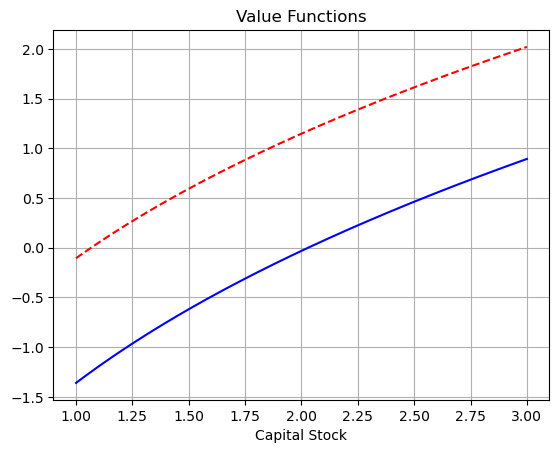

In [11]:
# Make plots of value and policy functions
fig, ax = plt.subplots()
ax.plot(k, V1[:,0], 'b')
ax.plot(k, V1[:,-1], 'r--')

ax.set(xlabel='Capital Stock', title='Value Functions')
ax.grid()

fig.savefig("plot_value.jpg", dpi=800)
plt.show()

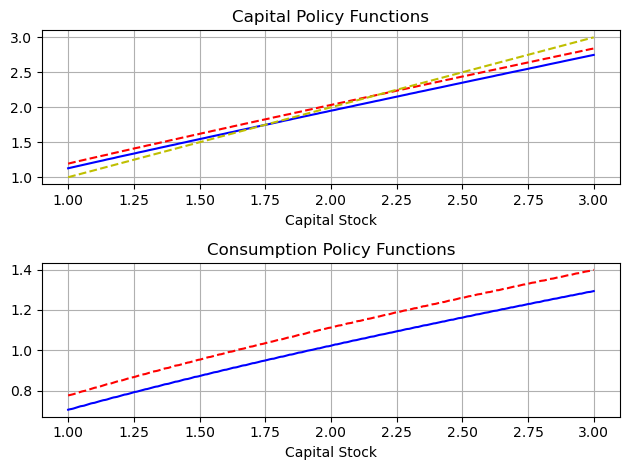

In [12]:
fig2, axs = plt.subplots(2, 1)

axs[0].plot(k, kpr[:,0], 'b')
axs[0].plot(k, kpr[:,-1], 'r--')
axs[0].plot(k, k, 'y--')
axs[0].set(xlabel='Capital Stock', title='Capital Policy Functions')
axs[0].grid()


axs[1].plot(k, polc[:,0], 'b')
axs[1].plot(k, polc[:,-1], 'r--')
axs[1].set(xlabel='Capital Stock', title='Consumption Policy Functions')
axs[1].grid()


plt.tight_layout()
plt.savefig('plot_policy.jpg', dpi=800)
plt.show()
plt.close(fig2)

In [13]:
# Simulation
if simyes == 1:
    # This is needed for the function random(), which returns a random floating point number in the range [0.0, 1.0)
    import random
    T = int(input('Enter the number of periods for simulation: '))
    
    ktime = np.zeros((T+1,))
    ctime = np.zeros((T,))
    intime = np.zeros((T,))
    tetatime = np.zeros((T+1,))
    tind = np.zeros((T+1,), dtype=int)
    
    tind[0] = 3
    kind = int(lk/2)-1
    tetatime[0] = teta[tind[0]]
    ktime[0]=k[kind]
    
    for ttime in np.arange(0,T):
        inc = tetatime[ttime]*ktime[ttime]**alfa + (1-delta)*ktime[ttime]
        ktime[ttime+1]=optimize.fminbound(func=maxlininterpol,x1=k[0],x2=min(inc-0.00001,k[lk-1]),\
                                        args=(V0,beta,inc,Pi,tind[ttime],k,),xtol=1e-04)
               
        ctime[ttime] = inc - ktime[ttime+1]
        intime[ttime] = ktime[ttime+1] - (1-delta)*ktime[ttime]
        shock = random.random()
        i = 0
        while Pi[tind[ttime],0:i+1].sum() < shock:
            i = i + 1
        
        tind[ttime+1] = i
        tetatime[ttime+1] = teta[i]
                       
    outime = tetatime*ktime**alfa                    

    #print('ktime=\n',ktime)
    #print('outime=\n',outime)
    #print('intime=\n',intime)
    #print('ctime=\n',ctime)
    #print('tetatime=\n',tetatime)
    #print('tind=\n',tind)

Enter the number of periods for simulation: 1000


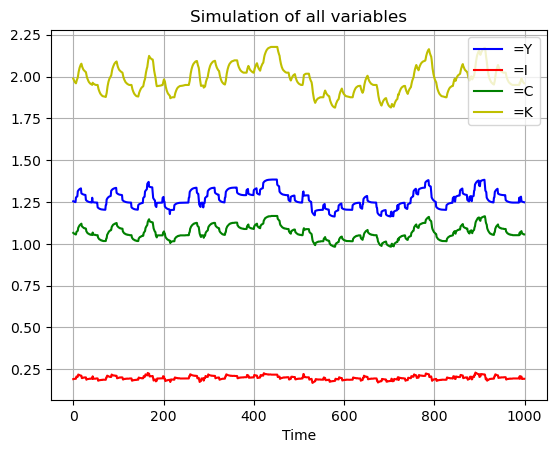

In [14]:
if simyes == 1:
    ttime = np.arange(0,T)
    
    # Make plots of value and policy functions
    fig3, ax3 = plt.subplots()
    ax3.plot(ttime, outime[1:T+1], 'b',label='=Y')
    ax3.plot(ttime, intime, 'r',label='=I')
    ax3.plot(ttime, ctime, 'g',label='=C')
    ax3.plot(ttime, ktime[1:T+1], 'y',label='=K')

    ax3.set(xlabel='Time', title='Simulation of all variables')
    ax3.grid()
    ax3.legend()

    fig3.savefig("plot_simul.jpg", dpi=800)
    plt.show()

In [15]:
if simyes == 1:
    X = np.concatenate((outime[0:T][:,np.newaxis], intime[:,np.newaxis], ctime[:,np.newaxis], ktime[0:T][:,np.newaxis]),axis=1)
    #print(X)
    #print(X.shape)
    
    # Some summary statistics
    print('Mean of output, investment, consumption, and capital')
    meanX=np.mean(X,axis=0)
    print(meanX)
    print('Volatility of output, investment, consumption, and capital')
    vol=np.std(X,axis=0)/np.mean(X,axis=0)
    print(vol)

Mean of output, investment, consumption, and capital
[1.2678 0.1984 1.0695 1.984 ]
Volatility of output, investment, consumption, and capital
[0.0415 0.0574 0.04   0.0423]
